# 1. Business Understanding

In this project I'm going to develop a pricing algorithm for houses in the northwest county based on a past collected data of house sales. The goal is to help homeowners save time on buying and/or selling houses.

This algorithm is predictive, meaning it will help stackeholders who want to buy or sell houses can use this algorithm to predcit house prices based on home renovations.

This algorithm will be able to tell us something about the relationship between attributes of houses and their prices. It other terms it will be inferential.


# Loading the data

In [257]:
# importing the necessary libraries for this project
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(21)

%matplotlib inline

In [258]:
# loading the dataset
df = pd.read_csv('./data/kc_house_data.csv', index_col='id')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

In [260]:
original_shape = df.shape 
original_shape

(21597, 20)

# 2. Data Understanding
 - Given is a a King County House Sales dataset. Which contains house attributes as well  as their prices. This is suitable for this project as we willl be using these attributes to predict the house prices.
 - The dataset has a total of 21,597 rows and 21 columns. Meaning 21,597 houses were taken as a sample and 21 of their existing attributes recorded.
 - Based on the sample given some attributes will sure help show the relationship between them and house prices.
 - The data also has some irrelevant columns which will be dropped, since they might hinder in creating a good model.


# 3. Data Preparation

The prediction target for this analysis is the proce of houses, hence will separate X and y appropiately

In [261]:
X = df.drop('price', axis=1)
y = df['price']

In [262]:
# splitting the data into a train and test sets, prior beforming any preprocesssing steps
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [263]:
print(f"X_train is a dataframe with {X_train.shape[0]} records and {X_train.shape[1]} attributes")
print(f"y_train is a series with {y_train.shape[0]} values")
print()
print(f"X_test has {X_test.shape[0]} records")
print(f"y_test has {y_test.shape[0]} records")

X_train is a dataframe with 16197 records and 19 attributes
y_train is a series with 16197 values

X_test has 5400 records
y_test has 5400 records


## Data Cleaning

### Functions to help with data Cleaning

In [264]:
# function to concate a set with its target variable
def concater(X, y):
    result = pd.concat([y, X], axis = 1)
    return result

In [265]:
# function to split concated set with its target variable and convert to floors and waterfront to integers
def set_splitter(dataset):
    X = dataset.drop('price', axis=1)
    y = dataset.price
    
    return X, y

## Handling with duplicated values

In [266]:
# concating the training set
concated_train = concater(X_train, y_train)

In [267]:
concated_train.duplicated().any()

False

## Handling with duplicated Values

Checking for null values in the train set

In [268]:
# Concating X_train and y_train
concated_train.isna().sum()

price               0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1788
view               47
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     2885
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Handling Mising Values

### Dealing with yr_renovated null values

In [269]:
# Checking for the values in thr yr_renovated column
concated_train['yr_renovated'].value_counts()

0.0       12750
2014.0       52
2003.0       24
2005.0       23
2000.0       23
          ...  
1959.0        1
1945.0        1
1944.0        1
1948.0        1
1953.0        1
Name: yr_renovated, Length: 65, dtype: int64

#### For yr_renovated I will use SimpleImputer to help deal with the null values

In [270]:
#  function for dealing with null values in a given set based on the yr_renovated column
def yr_renovated(concated_set):
    # creating a dataframe which contains the yr_renovated columns
    # NB: The houses without renavations have been filtered out
    year_renovated = concated_set[concated_set['yr_renovated'] != 0][['yr_renovated']]

    # using simpleImputer to deal with the null values in the yr_renovated column
    imput = SimpleImputer(missing_values=np.nan, strategy='median')
    imput.fit(year_renovated)
    new_year_renovated = imput.transform(year_renovated).flatten()
    year_renovated['yr_renovated'] = new_year_renovated

    condition = (
        concated_set.yr_renovated != 0 &
        concated_set.yr_renovated.isna()
    )

    # reassing the variables to the yr_renovated column strictly with columns whose values are not in the 0
    concated_set.loc[condition, 'yr_renovated'] = year_renovated

    return concated_set

In [271]:
# dealing with null values in the concated_train set
concated_train = yr_renovated(concated_train)
concated_train.isna().sum()

price               0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1788
view               47
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with null values in the view column

In [272]:
# checking for the unique values in the column and their occurence
concated_train.view.value_counts()

0.0    14585
2.0      718
3.0      356
4.0      246
1.0      245
Name: view, dtype: int64

In [273]:
#  function for dealing with null values in a given set based on the view column
def view(concated_set):
    # creating a dataframe which contains the view columns
    view = concated_set[['view']]

    # using simpleImputer to deal with the null values in the view column
    imput = SimpleImputer(missing_values=np.nan, strategy='median')
    imput.fit(view)
    new_view = imput.transform(view).flatten()
    view.view = new_view

    # condition = (concated_set.view.isna())

    # reassing the variables to the view column strictly with columns whose values are not in the 0
    concated_set.view = view

    return concated_set

In [274]:
concated_train = view(concated_train)
concated_train.isna().sum()

/tmp/ipykernel_83665/3432681625.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view.view = new_view


price               0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1788
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with null values in the waterfront column

In [275]:
concated_train.waterfront.value_counts()

0.0    14297
1.0      112
Name: waterfront, dtype: int64

In [276]:
#  function for dealing with null values in a given set based on the waterfront column
def waterfront(concated_set):
    # creating a dataframe which contains the waterfront columns
    waterfront = concated_set[['waterfront']]

    # using simpleImputer to deal with the null values in the waterfront column
    imput = SimpleImputer(missing_values=np.nan, strategy='median')
    imput.fit(waterfront)
    new_waterfront = imput.transform(waterfront).flatten()
    waterfront.waterfront = new_waterfront


    # reassing the variables to the waterfront column strictly with columns whose values are not in the 0
    concated_set.waterfront = waterfront

    return concated_set

In [277]:
concated_train = waterfront(concated_train)
concated_train.isna().sum()

/tmp/ipykernel_83665/598743563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waterfront.waterfront = new_waterfront


price            0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [278]:
print(f"The train set now has {concated_train.shape[0]} records")

The train set now has 16197 records


In [279]:
# Full function for the data cleaning
def data_cleaning(X, y):
    concated_set = concater(X, y)
    concated_set = yr_renovated(concated_set)
    concated_set = view(concated_set)
    concated_set = waterfront(concated_set)

    return concated_set

## Dealing with datatypes

In [280]:
concated_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16197 entries, 4139480190 to 1336800880
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          16197 non-null  float64
 1   date           16197 non-null  object 
 2   bedrooms       16197 non-null  int64  
 3   bathrooms      16197 non-null  float64
 4   sqft_living    16197 non-null  int64  
 5   sqft_lot       16197 non-null  int64  
 6   floors         16197 non-null  float64
 7   waterfront     16197 non-null  float64
 8   view           16197 non-null  float64
 9   condition      16197 non-null  int64  
 10  grade          16197 non-null  int64  
 11  sqft_above     16197 non-null  int64  
 12  sqft_basement  16197 non-null  object 
 13  yr_built       16197 non-null  int64  
 14  yr_renovated   16197 non-null  float64
 15  zipcode        16197 non-null  int64  
 16  lat            16197 non-null  float64
 17  long           16197 non-null  float

The function below will help with dealing of datatypes by drop irrelevant columns that is the sqft_living15 & sqft_lot15 columns.

In [281]:
def cleaner(concated_set):
    concated_set = concated_set.drop(['date','zipcode','sqft_living15','sqft_lot15'], axis=1)
    concated_set.bathrooms = round((concated_set.bathrooms * concated_set.bedrooms),0)
    return concated_set

concated_train = cleaner(concated_train)
concated_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16197 entries, 4139480190 to 1336800880
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          16197 non-null  float64
 1   bedrooms       16197 non-null  int64  
 2   bathrooms      16197 non-null  float64
 3   sqft_living    16197 non-null  int64  
 4   sqft_lot       16197 non-null  int64  
 5   floors         16197 non-null  float64
 6   waterfront     16197 non-null  float64
 7   view           16197 non-null  float64
 8   condition      16197 non-null  int64  
 9   grade          16197 non-null  int64  
 10  sqft_above     16197 non-null  int64  
 11  sqft_basement  16197 non-null  object 
 12  yr_built       16197 non-null  int64  
 13  yr_renovated   16197 non-null  float64
 14  lat            16197 non-null  float64
 15  long           16197 non-null  float64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.1+ MB


Invstigating the sqft_basement column

The sqft_basement has a string in some of its records this will hinder the data modelling process hence I will filter the records containing the '?' string out.

In [282]:
# The records containing ? could be that their sqft_basement is unknown
# Function to filter out the strings from the sqft_basement column
# The function will also change the column's columns data type to an int
def sqft_basement(concated_set):
    concated_set = concated_set[ (concated_set['sqft_basement'] != '?') ]
    concated_set['sqft_basement'] = pd.to_numeric(concated_set['sqft_basement'])
    return concated_set

concated_train = sqft_basement(concated_train)
concated_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15850 entries, 4139480190 to 1336800880
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15850 non-null  float64
 1   bedrooms       15850 non-null  int64  
 2   bathrooms      15850 non-null  float64
 3   sqft_living    15850 non-null  int64  
 4   sqft_lot       15850 non-null  int64  
 5   floors         15850 non-null  float64
 6   waterfront     15850 non-null  float64
 7   view           15850 non-null  float64
 8   condition      15850 non-null  int64  
 9   grade          15850 non-null  int64  
 10  sqft_above     15850 non-null  int64  
 11  sqft_basement  15850 non-null  float64
 12  yr_built       15850 non-null  int64  
 13  yr_renovated   15850 non-null  float64
 14  lat            15850 non-null  float64
 15  long           15850 non-null  float64
dtypes: float64(9), int64(7)
memory usage: 2.1 MB


/tmp/ipykernel_83665/99383065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concated_set['sqft_basement'] = pd.to_numeric(concated_set['sqft_basement'])


## A histogram showing the distribution of the target variable (house price)

Text(0.5, 1.0, 'Distribution of house prices')

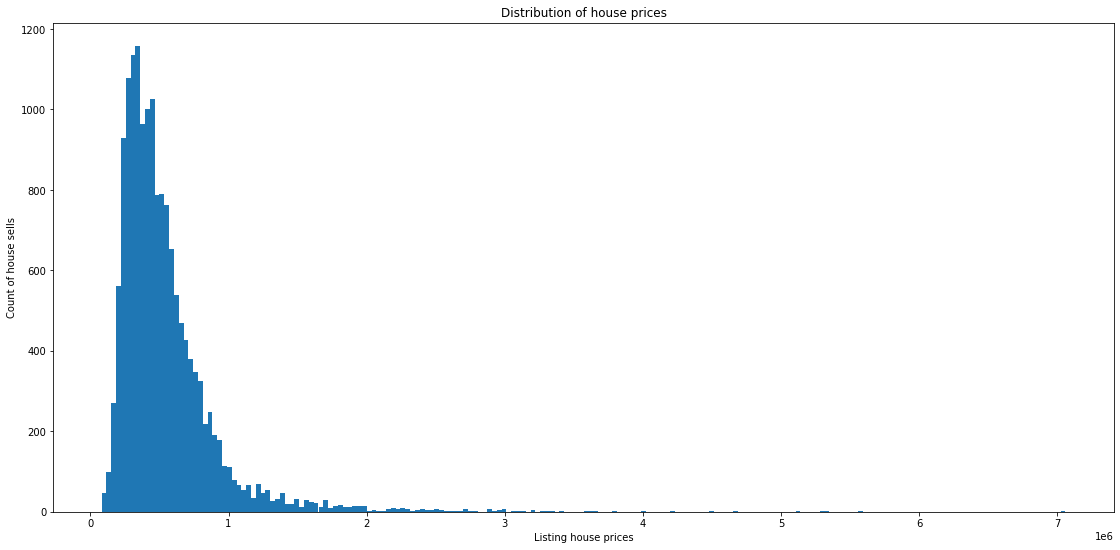

In [283]:
fig, ax = plt.subplots(figsize=(19,9))

ax.hist(concated_train.price, bins=200)


ax.set_xlabel('Listing house prices')
ax.set_ylabel('Count of house sells')
ax.set_title('Distribution of house prices')

In [284]:
concated_train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long
count,1.585000e+04,15850.000000,15850.000000,15850.000000,1.585000e+04,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000,15850.000000
mean,5.417747e+05,3.374069,7.529842,2082.674890,1.504003e+04,1.493470,0.006877,0.230410,3.410978,7.664732,1793.459874,289.215016,1970.980757,424.104227,47.560370,-122.213879
std,3.680227e+05,0.920293,4.204775,921.270864,3.914038e+04,0.537247,0.082644,0.761997,0.650615,1.176418,831.778252,441.090699,29.283014,817.403484,0.138689,0.139895
min,8.100000e+04,1.000000,0.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000
25%,3.220000e+05,3.000000,4.000000,1420.000000,5.043000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,47.470300,-122.327000
50%,4.500000e+05,3.000000,7.000000,1910.000000,7.646000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.572400,-122.229500
75%,6.450000e+05,4.000000,10.000000,2550.000000,1.064750e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,550.000000,1996.000000,0.000000,47.678175,-122.124000
max,7.060000e+06,33.000000,68.000000,13540.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.316000


In [285]:
# function to check for outliers
def outliers(concated_set):
    outliers = {}
    columns = ['price','sqft_living','sqft_lot','sqft_above']
    # columns = ['price','sqft_living']

    for column in columns:
        quantile1, quantile2 = concated_set[column].quantile([0.001,0.99])
        outliers[column] = []

        for i in concated_set[column]:
            if (i < quantile1) | (i > quantile2):
                outliers[column].append(i)


    return outliers


In [286]:
concated_train_ouliers = outliers(concated_train)

In [287]:
concated_train_ouliers

{'price': [2130000.0,
  2140000.0,
  2190000.0,
  2200000.0,
  2150000.0,
  2000000.0,
  2540000.0,
  2600000.0,
  2300000.0,
  2150000.0,
  2050000.0,
  2700000.0,
  90000.0,
  3300000.0,
  3400000.0,
  2450000.0,
  2000000.0,
  2450000.0,
  2880000.0,
  2070000.0,
  2300000.0,
  90000.0,
  2540000.0,
  2200000.0,
  2950000.0,
  2200000.0,
  3280000.0,
  2480000.0,
  2540000.0,
  3400000.0,
  2400000.0,
  2500000.0,
  3350000.0,
  90000.0,
  3070000.0,
  2700000.0,
  2890000.0,
  4000000.0,
  2400000.0,
  2150000.0,
  3100000.0,
  2250000.0,
  2300000.0,
  5570000.0,
  2250000.0,
  2250000.0,
  2300000.0,
  2560000.0,
  3200000.0,
  3000000.0,
  2890000.0,
  83000.0,
  2250000.0,
  2900000.0,
  2800000.0,
  2300000.0,
  4670000.0,
  3650000.0,
  3600000.0,
  2400000.0,
  2950000.0,
  2240000.0,
  2100000.0,
  2130000.0,
  3640000.0,
  2230000.0,
  2490000.0,
  2900000.0,
  2180000.0,
  2030000.0,
  89950.0,
  2700000.0,
  4490000.0,
  7060000.0,
  3120000.0,
  2350000.0,
  2580000.0,


In [288]:
# function to remove outliers and returns the new updated dataframe
def outliers_remover(concated_set, outliers):
    keys = list(outliers.keys())
    for key in keys:
        for i in outliers[key]:
            row_index = concated_set[ concated_set.price == i ].index
            concated_set = concated_set.drop(row_index)
    return concated_set

In [289]:
print(f"Number of train set records before removing outliers {concated_train.shape[0]}")
print()
concated_train = outliers_remover(concated_train, concated_train_ouliers)
print(f"Number of train set records after removing outliers {concated_train.shape[0]}")

Number of train set records before removing outliers 15850

Number of train set records after removing outliers 15673


### A histogram showing the distribution of the target variable (house price) after removing the outliers

Text(0.5, 1.0, 'Distribution of house prices')

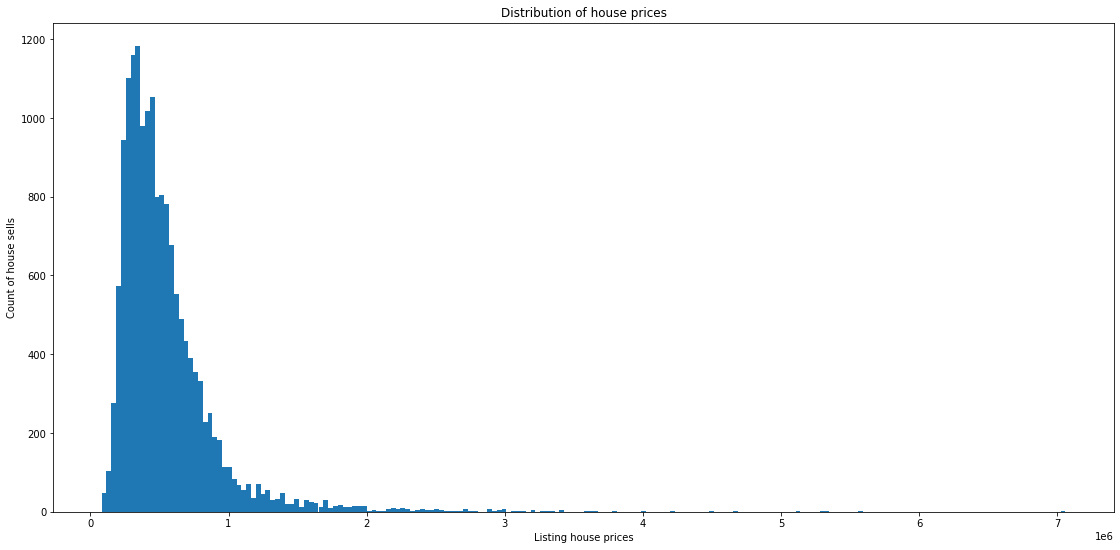

In [290]:
fig, ax = plt.subplots(figsize=(19,9))

ax.hist(y_train, bins=200)

ax.set_xlabel('Listing house prices')
ax.set_ylabel('Count of house sells')
ax.set_title('Distribution of house prices')

In [291]:
# full function for data preparation
def data_preparation(X,y):
    concated_set  = data_cleaning(X,y) # data cleaning function

    # dealing with the data types
    concated_set = cleaner(concated_set)
    concated_set = sqft_basement(concated_set)

    # dealing with outliers and removing them
    concated_set = outliers_remover(
        concated_set, 
        outliers(concated_set)
        ) # removing outliers


    return concated_set

# 4. Modeling

In [292]:
# splitting the data into X and y
X_train, y_train = set_splitter(concated_train)


In [293]:
# Intializing a splitter
splitter = ShuffleSplit(
    n_splits=3,
    test_size=0.25,
    random_state=20
) # perfoms a 5 seperate train-test splits 

In [294]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15673 entries, 4139480190 to 1336800880
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15673 non-null  int64  
 1   bathrooms      15673 non-null  float64
 2   sqft_living    15673 non-null  int64  
 3   sqft_lot       15673 non-null  int64  
 4   floors         15673 non-null  float64
 5   waterfront     15673 non-null  float64
 6   view           15673 non-null  float64
 7   condition      15673 non-null  int64  
 8   grade          15673 non-null  int64  
 9   sqft_above     15673 non-null  int64  
 10  sqft_basement  15673 non-null  float64
 11  yr_built       15673 non-null  int64  
 12  yr_renovated   15673 non-null  float64
 13  lat            15673 non-null  float64
 14  long           15673 non-null  float64
dtypes: float64(8), int64(7)
memory usage: 1.9 MB


In [295]:
# using REFCV
X_train_REFECV = StandardScaler().fit_transform(X_train)

model_for_REFECV = LinearRegression()

# Intitate and fit the selector
selector = RFECV(model_for_REFECV, cv=splitter)
selector.fit(X_train_REFECV, y_train)

# Print the results
print("Was the column selected")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: True
waterfront: True
view: True
condition: True
grade: True
sqft_above: True
sqft_basement: True
yr_built: True
yr_renovated: True
lat: True
long: True


The algorithim selects all the attributes hence I will use dive more to other alternatives to find the best combinators

In [296]:
len(X_train.columns)

15

In [297]:
# investigating for multicolinearity
olsmodel = sm.OLS(y_train, sm.add_constant(X_train)).fit()
olsmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     2667.
Date:                Sat, 02 Jul 2022   Prob (F-statistic):               0.00
Time:                        08:36:05   Log-Likelihood:            -2.0963e+05
No. Observations:               15673   AIC:                         4.193e+05
Df Residuals:                   15658   BIC:                         4.194e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.708e+07   1.43e+06    -18.984      0.000   -2.99e+07   -2.43e+07
bedrooms      -3.405e+04   2395.823    -14.214      0.000   -3.87e+04   -2.94e+04
bathrooms      8691.3427    712.594     12.197      0.000    7294.576    1.01e+04
sqft_living      79.9154      1.996     40.030      0.000      76.002      83.828
sqft_lot          0.0489      0.034      1.430      0.153      -0.018       0.116
floors         1.849e+04   3228.199      5.726      0.000    1.22e+04    2.48e+04
waterfront     3.149e+05   1.96e+04     16.068      0.000    2.76e+05    3.53e+05
view           4.506e+04   1954.655     23.055      0.000    4.12e+04    4.89e+04
condition      2.949e+04   2103.230     14.022      0.000    2.54e+04    3.36e+04
grade          1.039e+05   1884.106     55.132      0.000       1e+05    1.08e+05
sqft_above       46.9883      1.997     23.529      0.000      43.074      50.903
sqft_basement    32.9270      2.427     13.567      0.000      28.170      37.684
yr_built      -2226.1129     62.009    -35.900      0.000   -2347.657   -2104.569
yr_renovated      4.3491      1.540      2.824      0.005       1.330       7.368
lat            5.511e+05   9483.021     58.117      0.000    5.33e+05     5.7e+05
long          -3.788e+04   1.07e+04     -3.541      0.000   -5.89e+04   -1.69e+04
==============================================================================
Omnibus:                     5012.955   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28642.208
Skew:                           1.421   Prob(JB):                         0.00
Kurtosis:                       8.982   Cond. No.                     9.17e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.17e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Again we are not getting clear result hence I will use a brute force algorithm to find the best combinations to get the best results

In [298]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15673 entries, 4139480190 to 1336800880
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15673 non-null  int64  
 1   bathrooms      15673 non-null  float64
 2   sqft_living    15673 non-null  int64  
 3   sqft_lot       15673 non-null  int64  
 4   floors         15673 non-null  float64
 5   waterfront     15673 non-null  float64
 6   view           15673 non-null  float64
 7   condition      15673 non-null  int64  
 8   grade          15673 non-null  int64  
 9   sqft_above     15673 non-null  int64  
 10  sqft_basement  15673 non-null  float64
 11  yr_built       15673 non-null  int64  
 12  yr_renovated   15673 non-null  float64
 13  lat            15673 non-null  float64
 14  long           15673 non-null  float64
dtypes: float64(8), int64(7)
memory usage: 1.9 MB


In [299]:
# Function for getting coeeficients in a cross_valiate
def coeeficients(score):
    for model in score['estimator']:
        print(model.coef_)

## Building models to find the best model overall

### First Model 

The first model will contain all the attributes

In [300]:
first_model = LinearRegression()

first_score = cross_validate(
    estimator=first_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)

print(f"Train Score:            {first_score['train_score'].mean()}")
print(f"Validation Score:       {first_score['test_score'].mean()}")
print(f"Difference in scores:   {  (first_score['train_score'].mean()) - (first_score['test_score'].mean())}")


Train Score:            0.704925381875
Validation Score:       0.7028225765891835
Difference in scores:   0.0021028052858165225


The model had a good R-2 and the difference between the models is low, hence it does a good job in predicting the house prices

### Second Model 

The second model will be built using the PolynomialFeature

In [301]:
# Building a less complex polynomial feature 
poly_2 = PolynomialFeatures(2)
X_train_poly2 = poly_2.fit_transform(X_train)

In [302]:
second_model_poly_2 = LinearRegression()

second_score = cross_validate(
    estimator=second_model_poly_2,
    X=X_train_poly2,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)
print(f"Train Score:            {second_score['train_score'].mean()}")
print(f"Validation Score:       {second_score['test_score'].mean()}")
print(f"Difference in scores:   {  (second_score['train_score'].mean()) - (second_score['test_score'].mean())}")

Train Score:            0.7655834182947941
Validation Score:       0.7574651840694652
Difference in scores:   0.00811823422532898


Both the score are higher than compared to the first model whose R-2 was a bit lower, also the diffence between the score is low hence this model does a better in prediction

### Third Model 

In [303]:
# Building a more complex polynomial feature 
poly_3 = PolynomialFeatures(3)
X_train_poly3 = poly_3.fit_transform(X_train)

In [304]:
third_model_poly_3 = LinearRegression()

third_score = cross_validate(
    estimator=third_model_poly_3,
    X=X_train_poly3,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)
print(f"Train Score:            {third_score['train_score'].mean()}")
print(f"Validation Score:       {third_score['test_score'].mean()}")
print(f"Difference in scores:   {  (third_score['train_score'].mean()) - (third_score['test_score'].mean())}")

Train Score:            0.7777447705556589
Validation Score:       0.6298948444992012
Difference in scores:   0.14784992605645775


This model performed bad, it scored a good train score but a less validation score hence it is overfitting.

Going back to the OLS model

### Building a heat map to show correlation between all train set attributes and their target which is the house price

<AxesSubplot:>

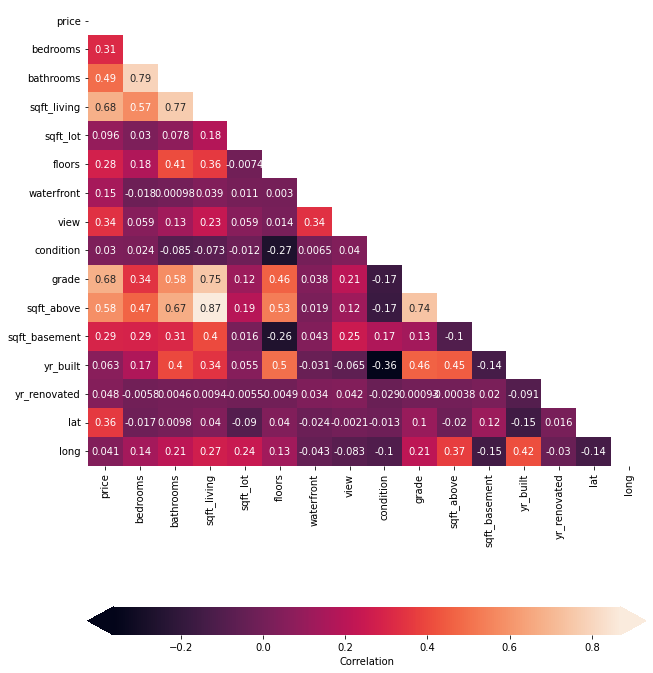

In [305]:
heatmap_x = concated_train

train_test_corr = heatmap_x.corr()
fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
    # Specifies the data to be plotted
    data = train_test_corr,
    # The mask means we only show half the values, instead of showing duplicates.
    mask= np.triu(np.ones_like(train_test_corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizing colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

### Fourth Model 

In this model I will select all features with a a high coefficient

In [306]:
# selecting all attributes with a p value of 0.0000 and checking if they suit for a good model
signficant_features = ['sqft_living','grade'] 


For this model I will use the second_model to model our fourth model with the significant_features to see if they will perform well

In [307]:
X_train_fourth_model = X_train[signficant_features]

In [308]:
fourth_model = LinearRegression()

fourth_score = cross_validate(
    estimator=fourth_model,
    X=X_train_fourth_model,
    y=y_train,
    return_train_score=True,
    return_estimator=True,
    cv=splitter
)
print(f"Train Score:            {fourth_score['train_score'].mean()}")
print(f"Validation Score:       {fourth_score['test_score'].mean()}")
print(f"Difference in scores:   {  (fourth_score['train_score'].mean()) - (fourth_score['test_score'].mean())}")

Train Score:            0.5288718647623504
Validation Score:       0.5293588966276568
Difference in scores:   -0.00048703186530640874


The fourth model perfomed had a better difference in scores than the other models, making it the best model

### Building and evaluating a final Model

#### First I'll perform data preparation to the test set

using the data_preparation function I will prepare the training set

In [309]:
# creating a ready and cleaned set
concated_test = data_preparation(X_test, y_test)

/tmp/ipykernel_83665/3432681625.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view.view = new_view
/tmp/ipykernel_83665/598743563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waterfront.waterfront = new_waterfront
/tmp/ipykernel_83665/99383065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [310]:
concated_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5235 entries, 2997800076 to 148000440
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          5235 non-null   float64
 1   bedrooms       5235 non-null   int64  
 2   bathrooms      5235 non-null   float64
 3   sqft_living    5235 non-null   int64  
 4   sqft_lot       5235 non-null   int64  
 5   floors         5235 non-null   float64
 6   waterfront     5235 non-null   float64
 7   view           5235 non-null   float64
 8   condition      5235 non-null   int64  
 9   grade          5235 non-null   int64  
 10  sqft_above     5235 non-null   int64  
 11  sqft_basement  5235 non-null   float64
 12  yr_built       5235 non-null   int64  
 13  yr_renovated   5235 non-null   float64
 14  lat            5235 non-null   float64
 15  long           5235 non-null   float64
dtypes: float64(9), int64(7)
memory usage: 695.3 KB


In [311]:
# checking for null values in the testing 
concated_test.isna().any().any()

False

Finally splitting the prepared train set using the set_splitter function

In [312]:
X_test, y_test = set_splitter(concated_test)

In [313]:
display(len(X_test))
len(y_test)

5235

5235

This model will be based on the fourth since it performed well

In [314]:
final_model = first_model
final_model.fit(X_train[signficant_features], y_train)


# scoring the model on the X_test and the y_test
final_model.score(X_test[signficant_features], y_test)

0.5236573774974072

The model perfmed well to on the test set

## Computing the RMSE

In [315]:
mean_squared_error(y_test, final_model.predict(X_test[signficant_features]), squared=False)

194173.94339719572

This means that for every house price predicted with this model the house price will be off will with approximately $ 194173.94

## Interpreting the Final Model

Below are the coefficients of the model

In [317]:
final_model_coefficients = pd.Series(final_model.coef_,index=signficant_features, name='coefficients')
final_model_coefficients

sqft_living      129.470414
grade          97712.128672
Name: coefficients, dtype: float64

## Investigating Linearity

Text(0, 0.5, 'Predicted Price')

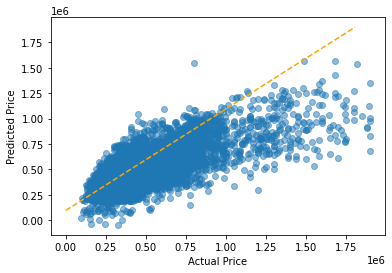

In [318]:
predictions = final_model.predict(X_test[signficant_features])
fig,ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())

ax.plot(perfect_line, linestyle='--', color='orange', label='perfect fit')
ax.scatter(y_test, predictions, alpha=0.5)

ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

The model is hitting a good number of points hence we are not violating the linear consumption.

## Investigating normality

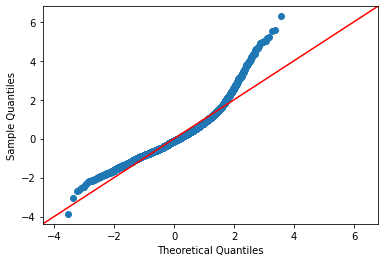

In [319]:
residuals = (y_test - predictions)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

We are not violating the normality assumptions hence the model passes the normality assumption test

## Investigating Homoscedacity

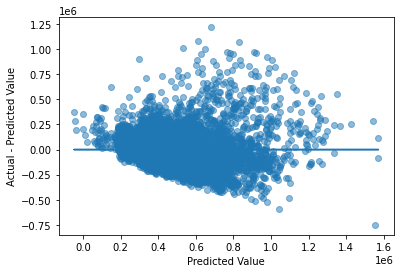

In [321]:
# Run this cell without changes
fig, ax = plt.subplots()

ax.scatter(predictions, residuals, alpha=0.5)
ax.plot(predictions, [0 for i in range(len(X_test[signficant_features]))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

This is somehow a funnel shape, hence could be violating one strict rule of of homoscedacity

### Conclusion

We can but medium confidence on this model since it is off by $ 194173.94 which is alot of money.